# Prepare torch sample

In [1]:
import torch


X_full = torch.load("sample.pt")
X_full = torch.rot90(X_full, 1, [1, 2])

# unnormalize X_full with Mean: 2.1744942665100098, std: 3.9583189487457275
# X_full = X_full * 3.9583189487457275 + 2.1744942665100098
truth = X_full[30,:]

# truth = X_full.unsqueeze(0).unsqueeze(0)  # Reshape input tensor to have spatial dimensions

measurements = torch.nn.functional.interpolate(truth.unsqueeze(0).unsqueeze(0), size=(5, 6), mode='bilinear', align_corners=False)

# measurements = torch.ones_like(measurements)*10
measurements = measurements.view(-1)

In [2]:
measurements[0] = 1
measurements[1] = 1
measurements[24] = 1
measurements[25] = 1

In [3]:
import numpy as np
import scipy.sparse
from scipy.interpolate import griddata
# from scipy.sparse import diags
import matplotlib.tri as tri
from sklearn import linear_model
import torch
# from sklearn.metrics import mean_squared_error

# Parameters
source = np.array([4., 4.])
wind_x = 0.0
wind_y = 0.0
kappa = 0.2
num_msmt = 30

class DARES:
    def __init__(self, laplace="laplace.npz", grad_x="grad_x.npz", grad_y="grad_y.npz", verts="vertices.npy"):
        # Load operators and mesh
        L = scipy.sparse.load_npz(laplace)
        Gx = scipy.sparse.load_npz(grad_x)
        Gy = scipy.sparse.load_npz(grad_y)
        self.verts = np.load(verts)
        self.dim = self.verts.shape[0]

        # Mesh boundaries
        self.x_min, self.x_max = np.min(self.verts[:, 0]), np.max(self.verts[:, 0])
        self.y_min, self.y_max = np.min(self.verts[:, 1]), np.max(self.verts[:, 1])

        # Find border
        eps = 0.05
        b = 1. * np.logical_or(np.logical_or(self.verts[:, 0] < eps + self.x_min, self.verts[:, 0] > self.x_max - eps),
                            np.logical_or(self.verts[:, 1] < eps + self.y_min, self.verts[:, 1] > self.y_max - eps))

        # Set boundary condition (i.e., = 0)
        R = scipy.sparse.diags(b)
        # r = np.zeros((self.dim, 1))

        # PDE
        O = kappa * L + wind_x * Gx + wind_y * Gy
        # Combine model and boundary condition into one matrix
        O[b == 1] = R.todense()[b == 1]
        self.Oinv = np.linalg.inv(O.todense())

    def set_measurements(self, measurements):
        # Simulate measurements on a 6x5 grid
        start_x = start_y = 0.75
        spacing = 1.5
        grid_x = start_x + spacing * np.arange(6)
        grid_y = start_y + spacing * np.arange(5)
        sensor_locs = np.array([(x, y) for y in grid_y for x in grid_x])

        # Initialize measurement matrix
        self.M = np.zeros((num_msmt, self.dim))
        self.m = np.zeros((num_msmt, 1))

        # Fill the measurement matrix
        for i, (x, y) in enumerate(sensor_locs):
            idx = np.argmin(np.linalg.norm(self.verts - np.array([x, y]), axis=1))
            self.M[i, idx] = 1
            self.m[i] = measurements[i]

    def reconstruct(self):

        # Lasso reconstruction
        clf = linear_model.Lasso(alpha=0.001)
        clf.fit(np.asarray(np.dot(self.M, self.Oinv)), self.m)
        q_rec = clf.coef_
        f_rec = np.array(np.dot(self.Oinv, q_rec))

        # Convert triangulated mesh to regular grid for visualization
        grid_x_regular, grid_y_regular = np.meshgrid(np.linspace(self.x_min, self.x_max, 30), np.linspace(self.y_min, self.y_max, 25))
        f_rec_grid = griddata(self.verts, f_rec.flatten(), (grid_x_regular, grid_y_regular), method='cubic')

        return f_rec_grid

dares = DARES()

dares.set_measurements(measurements.numpy())
f_rec_grid = dares.reconstruct()
# plt.imshow(f_rec_grid)

c:\Users\nwinkler\Miniconda3\envs\pyg\Lib\site-packages\scipy\sparse\_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


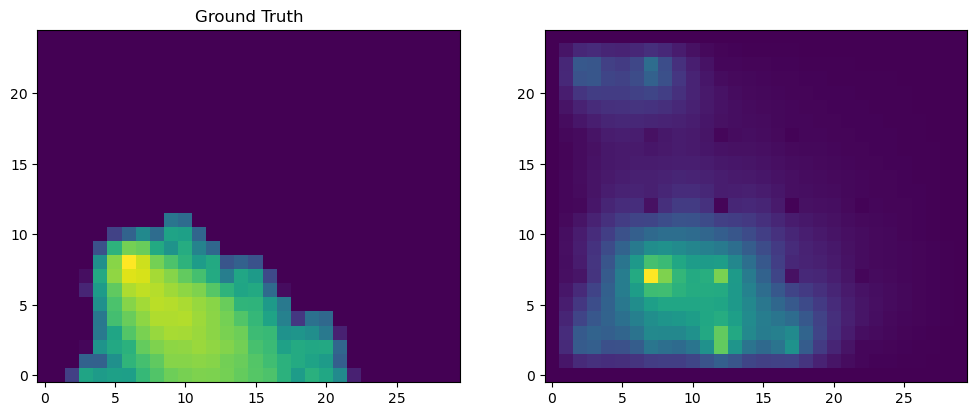

In [4]:
import matplotlib.pyplot as plt

# Plot ground truth and reconstruction
plt.figure(figsize=(12, 6))

# Ground truth on regular grid
plt.subplot(1, 2, 1)
# plt.contourf(grid_x_regular, grid_y_regular, truth_grid, levels=14, cmap='viridis')
plt.imshow(truth.squeeze(), origin='lower', cmap='viridis')
# plt.colorbar()
plt.title("Ground Truth")

# Reconstruction on regular grid
plt.subplot(1, 2, 2)
# plt.contourf(grid_x_regular, grid_y_regular, f_rec_grid, levels=14, cmap='viridis')
plt.imshow(f_rec_grid, origin='lower', cmap='viridis')
# plt.plot(sensor_locs[:, 0], sensor_locs[:, 1], "w*")
# plt.colorbar()
# plt.title(f"Reconstruction (MSE: {mse:.4f})")

plt.show()

In [5]:
f_rec.shape

NameError: name 'f_rec' is not defined

In [ ]:
f_rec.shape

(1, 3111)

/Users/nicolas/miniconda3/envs/pyg/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


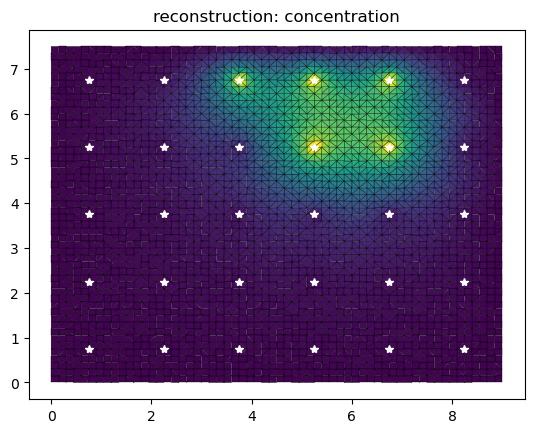

In [ ]:
y = torch.randn([25,30])
X = torch.randn([5,6])
measurements = X.view(-1)

import numpy as np
import scipy.sparse
from scipy.sparse import vstack, diags
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn import linear_model

#parameter
source=np.array([4.,4.])
wind_x=0.0
wind_y=0.0
kappa=0.2
num_msmt=30

##############################################################
# forward simulation

#load operators
L = scipy.sparse.load_npz('laplace.npz')
Gx = scipy.sparse.load_npz('grad_x.npz')
Gy = scipy.sparse.load_npz('grad_y.npz')

#load mesh
verts=np.load("vertices.npy")
dim=verts.shape[0]

# Rotate the mesh by 90 degrees (swap x and y, negate y)
# verts = np.dot(verts, np.array([[0, -1], [1, 0]]))
x_min=np.min(verts[:,0])
x_max=np.max(verts[:,0])
y_min=np.min(verts[:,1])
y_max=np.max(verts[:,1])

#find border
#eps=0.5*1./dim
eps=0.05
b=1.*np.logical_or(np.logical_or(verts[:,0]<eps+x_min,verts[:,0]>x_max-eps),np.logical_or(verts[:,1]<eps+y_min,verts[:,1]>y_max-eps))

#set boundary condition, i.e. =0
R=diags(b)
r=np.zeros((dim,1))

#PDE
O=kappa*L+wind_x*Gx+wind_y*Gy

##############################################################
# reconstruction

# Simulate measurements on a 6x5 grid
start_x = start_y = 0.75
spacing = 1.5
grid_x = start_x + spacing * np.arange(6)
grid_y = start_y + spacing * np.arange(5)
sensor_locs = np.array([(x, y) for y in grid_y for x in grid_x])

M = np.zeros((num_msmt, dim))
m = np.zeros((num_msmt, 1))

for i, (x, y) in enumerate(sensor_locs):
    idx = np.argmin(np.linalg.norm(verts - np.array([x, y]), axis=1))
    M[i, idx] = 1
    # m[i] = f[idx]
    m[i] = measurements[i]

#combine model and boundary condition into one matrix
O[b==1]=R.todense()[b==1]
Oinv=np.linalg.inv(O.todense())

#Lasso:
clf = linear_model.Lasso(alpha=0.001)
clf.fit(np.asarray(np.dot(M,Oinv)), m)
q_rec=clf.coef_

f_rec=np.array(np.dot(Oinv,q_rec))

#plot
plt.figure()
triang = tri.Triangulation(verts[:,0], verts[:,1])
plt.tripcolor(triang, f_rec.flatten(), edgecolors='k')
plt.plot(np.dot(M,verts[:,0]),np.dot(M,verts[:,1]),"w*")
plt.title("reconstruction: concentration")

plt.show()

In [ ]:
sensor_locs

array([[0.75, 0.75],
       [2.25, 0.75],
       [3.75, 0.75],
       [5.25, 0.75],
       [6.75, 0.75],
       [8.25, 0.75],
       [0.75, 2.25],
       [2.25, 2.25],
       [3.75, 2.25],
       [5.25, 2.25],
       [6.75, 2.25],
       [8.25, 2.25],
       [0.75, 3.75],
       [2.25, 3.75],
       [3.75, 3.75],
       [5.25, 3.75],
       [6.75, 3.75],
       [8.25, 3.75],
       [0.75, 5.25],
       [2.25, 5.25],
       [3.75, 5.25],
       [5.25, 5.25],
       [6.75, 5.25],
       [8.25, 5.25],
       [0.75, 6.75],
       [2.25, 6.75],
       [3.75, 6.75],
       [5.25, 6.75],
       [6.75, 6.75],
       [8.25, 6.75]])